In [1]:
import numpy as np
import pandas as pd
from numpy.random import uniform, normal 
from math import pi
from scipy.optimize import Bounds
from scipy.optimize import minimize
import matplotlib.pyplot as plt 

# ignore the warning message
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
def J_square(sigma_square,tau_square):
    return tau_square/(tau_square+sigma_square)

In [3]:
# k: the number of studies
k_list = [10,30,50,100]
# each element of `parameter_constellation` has the form (mu, sigma^2,tau^2) 
# where tau^2 is the between-study variance, sigma^2*u_i is the within-study variance
parameter_constellation = [(0,12,4),(0,9,4),(0,4,4),(0,2,6)]
# heterogeniety measure: J^2
J_square_list = list()
for element in parameter_constellation:
    sigma_square_i = element[1]
    tau_square_i = element[2]
    J_square_list.append(J_square(sigma_square_i,tau_square_i))
print('J square =',J_square_list)

J square = [0.25, 0.3076923076923077, 0.5, 0.75]


## when sigma^2 is known

### The negative log-likelihood function of $v = (\mu, \sigma^2, \tau^2)$ is given by

$I(v) = \frac{1}{2}\sum \limits_{i=1}^{k}[\frac{(D_i-\mu)^2}{\tau^2+\sigma^2 u_i}+\log{(\tau^2+\sigma^2 u_i)}+c]$

with first order derivatives (only two variables $\mu$ and $\tau^2$)
$$\frac{\partial l(v)}{\partial \mu} = \sum \limits_{i=1}^{k} \frac{D_i - \mu}{\tau^2 + \sigma^2 u_i}$$
$$\frac{\partial l(v)}{\partial \tau^2} = \sum \limits_{i=1}^{k} \frac{(D_i - \mu)^2}{(\tau^2 + \sigma^2 u_i)^2} - \sum \limits_{i=1}^{k} \frac{1}{\tau^2+\sigma^2 u_i}$$

Therefore, the Hessian of the log-likelihood function is
$$
\left[\begin{array}{cc} 
\sum \limits_{i=1}^{k} \frac{1}{\tau^2 + \sigma^2 u_i} & 0\\ 
0 & \frac{1}{2} \sum \limits_{i=1}^{k} \frac{1}{(\tau^2 + \sigma^2 u_i)^2}
\end{array}\right]
$$

And 
$$\frac{\partial l(v)}{\partial \mu} = 0 \Rightarrow \mu = \frac{\sum \limits_{i=1}^{k} \frac{D_i}{\tau^2 + \sigma^2 u_i}}{\sum \limits_{i=1}^{k} \frac{1}{\tau^2 + \sigma^2 u_i}} (\text{where } \tau^2 \text{ is unknown})$$ 
$$\frac{\partial l(v)}{\partial \tau^2} = 0 \Rightarrow \sum \limits_{i=1}^{k} \frac{(D_i - \mu)^2}{(\tau^2 + \sigma^2 u_i)^2} = \sum \limits_{i=1}^{k} \frac{1}{\tau^2+\sigma^2 u_i} = \sum \limits_{i=1}^{k} \frac{\tau^2+\sigma^2 u_i}{(\tau^2+\sigma^2 u_i)^2}$$
$$\Rightarrow \tau^2 = \frac{\sum \limits_{i=1}^{k} \frac{(D_i - \mu)^2 - \sigma^2 u_i}{(\tau^2 + \sigma^2 u_i)^2}}{\sum \limits_{i=1}^{k} \frac{1}{(\tau^2 + \sigma^2 u_i)^2}}$$

In [4]:
# function for generating u_array and D_array
def array_generator(k,mu,sigma,tau):
    # u in (0.01, 0.1) => n=1/u in (10,100)
    u_array = uniform(0.01,0.1,k)
    # x_i ~ N(mu,tau^2)
    x_array = normal(mu,tau,k)
    # D_i ~ N(x_i, sigma^2*u_i)
    D_array = normal(x_array,sigma*u_array**0.5,k)
    return u_array, D_array

In [5]:
# fix the simulated u_array and D_array in advance
# for avoiding randomness
two_generated_arrays = array_generator(k=100,mu=0,sigma=np.sqrt(12),tau=2)
u_array = two_generated_arrays[0]
D_array = two_generated_arrays[1]

### method 1: unconstrained optimization: minimize the negative log-likelihood function with BFGS method (using sigma/tau)

In [6]:
def nll_unknown_sigma(x, D, u):
    # x = np.array([mu, sigma, tau])
    mu, sigma, tau = x[0], x[1], x[2]
    sigma_square, tau_square = sigma**2, tau**2
    return 1/2*np.sum((D - mu)**2/(tau_square + sigma_square*u) \
            +np.log(tau_square + sigma_square*u)+np.log(2*pi))

# Jacobian: the matrix of all its first-order partial derivatives
def jac_unknown_sigma(x, D, u):
    mu, sigma, tau = x[0], x[1], x[2]
    sigma_square, tau_square = sigma**2, tau**2
    a = D - mu
    b = tau_square + sigma_square * u
    # convert the derivative with respect to sigma/tau, instead of sigma^2/tau^2
    d_mu = np.sum(a / b)
    d_sigma = (np.sum((a**2 * u) / b**2) - np.sum(u / b)) * (2*sigma) 
    d_tau = (np.sum(a**2 / b**2) - np.sum(1./ b)) * (2*tau)
    return - np.array([d_mu, d_sigma, d_tau])

def nll_known_sigma(x, D, u):
    # x = np.array([mu, tau])
    mu, tau = x[0], x[1], 
    tau_square = tau**2
    known_sigma_square = np.var(D)
    return 1/2*np.sum((D - mu)**2/(tau_square + known_sigma_square*u) \
            +np.log(tau_square + known_sigma_square*u)+np.log(2*pi))

def jac_known_sigma(x, D, u):
    mu, tau = x[0], x[1]
    tau_square = tau**2
    known_sigma_square = np.var(D)
    a = D - mu
    b = tau_square + known_sigma_square * u
    # convert the derivative with respect to sigma/tau, instead of sigma^2/tau^2
    d_mu = np.sum(a / b)
    d_tau = (np.sum(a**2 / b**2) - np.sum(1./ b)) * (2*tau)
    return - np.array([d_mu, d_tau])


In [7]:
def simulation_UC_unknown_sigma(D_array,u_array,stopping_criteria = 1e-10):
    # random but resonable initial point
    mu_0 = uniform(-2.0, 2.0)
    sigma_0 = uniform(0., 15.)
    tau_0 = uniform(0., 8.)
    x0 = np.array([mu_0, sigma_0, tau_0])
    minimizer = minimize(nll_unknown_sigma, x0, args=(D_array, u_array), method="BFGS", jac=jac_unknown_sigma, tol=stopping_criteria)   
    #minimizer_kwargs = {"method": "BFGS", "args": (D_array, u_array), "jac":True}
    # corresponding mu/sigma/tau when the negative log likelihood function is minimized
    mu_ast, sigma_ast, tau_ast = minimizer.x
    n_iteration = minimizer.nit
    sigma_square_ast = sigma_ast**2
    tau_square_ast = tau_ast**2
    return np.array([mu_ast, tau_square_ast, n_iteration])

In [8]:
simulation_UC_unknown_sigma(D_array,u_array,stopping_criteria = 1e-10)

array([-6.24172446e-03,  4.39107689e+00,  1.80000000e+01])

In [9]:
def simulation_UC_known_sigma(D_array,u_array,stopping_criteria = 1e-10):
    known_sigma= np.std(D_array)
    known_sigma_square= np.var(D_array)
    
    # random but resonable initial point
    mu_0 = uniform(-2.0, 2.0)
    tau_0 = uniform(0., 8.)
    x0 = np.array([mu_0, tau_0])
    minimizer = minimize(nll_known_sigma, x0, args=(D_array, u_array), method="BFGS", jac=jac_known_sigma, tol=stopping_criteria)   
    #minimizer_kwargs = {"method": "BFGS", "args": (D_array, u_array), "jac":True}
    # corresponding mu/sigma/tau when the negative log likelihood function is minimized
    mu_ast, tau_ast = minimizer.x
    n_iteration = minimizer.nit
    tau_square_ast = tau_ast**2
    return np.array([mu_ast, tau_square_ast, n_iteration])

In [10]:
simulation_UC_known_sigma(D_array,u_array,stopping_criteria = 1e-10)

array([-0.01177356,  4.17879255,  8.        ])

### method 2: constrained (bounded) optimization using tau^2 and sigma^2 (non-negative) with BFGS method

In [11]:
def CO_nll_unknown_sigma(x, D, u):
    # x = np.array([mu, sigma^2, tau^2])
    mu, sigma_square, tau_square = x[0], x[1], x[2]
    return 1/2*np.sum((D - mu)**2/(tau_square + sigma_square*u) \
            +np.log(tau_square + sigma_square*u)+np.log(2*pi))

# Jacobian: the matrix of all its first-order partial derivatives
def CO_jac_unknown_sigma(x, D, u):
    mu, sigma_square, tau_square = x[0], x[1], x[2]
    a = D - mu
    b = tau_square + sigma_square * u
    # convert the derivative with respect to sigma/tau, instead of sigma^2/tau^2
    d_mu = np.sum(a / b)
    d_sigma_square = (np.sum((a**2 * u) / b**2) - np.sum(u / b)) 
    d_tau_square = (np.sum(a**2 / b**2) - np.sum(1./ b))
    return - np.array([d_mu, d_sigma_square, d_tau_square])

def CO_nll_known_sigma(x, D, u):
    # x = np.array([mu, sigma^2, tau^2])
    mu, tau_square = x[0], x[1]
    known_sigma_square = np.var(D)
    return 1/2*np.sum((D - mu)**2/(tau_square + known_sigma_square*u) \
            +np.log(tau_square + known_sigma_square*u)+np.log(2*pi))

def CO_jac_known_sigma(x, D, u):
    mu, tau_square = x[0], x[1]
    known_sigma_square = np.var(D)
    a = D - mu
    b = tau_square + known_sigma_square * u
    # convert the derivative with respect to sigma/tau, instead of sigma^2/tau^2
    d_mu = np.sum(a / b) 
    d_tau_square = (np.sum(a**2 / b**2) - np.sum(1./ b))
    return - np.array([d_mu,d_tau_square])

In [12]:
def simulation_CO_unknown_sigma(D_array,u_array,stopping_criteria = 1e-10):
    # random but resonable initial point
    mu_0 = uniform(-2.0, 2.0)
    sigma_0 = uniform(0., 15.)
    tau_0 = uniform(0., 8.)
    
    sigma_square_0 = sigma_0**2
    tau_square_0 = tau_0**2
    
    x0 = np.array([mu_0, sigma_square_0, tau_square_0])
    bds = ((-np.inf, np.inf), (0, np.inf), (0, np.inf))
    
    minimizer = minimize(CO_nll_unknown_sigma, x0, args=(D_array, u_array), method="BFGS", jac=CO_jac_unknown_sigma, bounds=bds, tol=stopping_criteria)   
    mu_ast, sigma_square_ast, tau_square_ast = minimizer.x
    n_iteration = minimizer.nit
    return np.array([mu_ast, tau_square_ast, n_iteration])

In [13]:
simulation_CO_unknown_sigma(D_array,u_array,stopping_criteria = 1e-10)

array([1.86986643e-02, 5.40350030e+00, 2.80000000e+01])

In [14]:
def simulation_CO_known_sigma(D_array,u_array,stopping_criteria = 1e-10):
    # random but resonable initial point
    mu_0 = uniform(-2.0, 2.0)
    tau_0 = uniform(0., 8.)
    tau_square_0 = tau_0**2
    
    x0 = np.array([mu_0, tau_square_0])
    bds = ((-np.inf, np.inf), (0, np.inf))
    
    minimizer = minimize(CO_nll_known_sigma, x0, args=(D_array, u_array), method="BFGS", jac=CO_jac_known_sigma, bounds=bds, tol=stopping_criteria)   
    mu_ast, tau_square_ast = minimizer.x
    n_iteration = minimizer.nit
    return np.array([mu_ast, tau_square_ast, n_iteration])

In [15]:
simulation_CO_known_sigma(D_array,u_array,stopping_criteria = 1e-10)

array([-1.17735598e-02,  4.17879254e+00,  1.30000000e+01])

### method 3: fixed point algorithm (using sigma^2/tau^2 as the stopping criteria)

### starting value: $$\hat{\tau}_0^2 = 0$$
$$\hat{\mu}_0 = \frac{\sum \limits_{i=1}^{k} \frac{D_i}{u_i}}{\sum \limits_{i=1}^{k} \frac{1}{u_i}}$$

### iterative process
$$\mu_{s+1} = \frac{\sum \limits_{i=1}^{k} \frac{D_i}{\tau_{s}^2+\sigma^2 u_i}}{\sum \limits_{i=1}^{k} \frac{1}{\tau_{s}^2+\sigma^2 u_i}}$$

$$\Rightarrow \tau_{s+1}^2 = \frac{\sum \limits_{i=1}^{k} \frac{(D_i - \mu_{s})^2 - \sigma^2 u_i}{(\tau_{s}^2 + \sigma^2 u_i)^2}}{\sum \limits_{i=1}^{k} \frac{1}{(\tau_{s}^2 + \sigma^2 u_i)^2}}$$
where $\sigma^2$ is known from the beginning

In [16]:
# function for finding estimated mu/sigma^2/tau^2 for given D_array and u_array
# using fixed point algrithm with unknown sigma
def simulation_FP_unknown_sigma(D_array,u_array,stopping_criteria = 1e-10,max_iter=1000):
    k = D_array.shape[0]
    u_inv_array = 1/u_array
    # starting value
    tau_square_hat_0 = 0
    mu_hat_0 = np.sum(D_array*u_inv_array)/np.sum(u_inv_array)
    sigma_square_hat_0 = 1/k*np.sum((D_array - mu_hat_0)**2/u_array)
    
    log_likelihood = -1/2*np.sum((D_array - mu_hat_0)**2/(tau_square_hat_0 + sigma_square_hat_0*u_array)+np.log(tau_square_hat_0 + sigma_square_hat_0*u_array)+np.log(2*pi))
    #print('The log likelihood corresponding to starting values is', log_likelihood)

    mu = mu_hat_0
    tau_square = tau_square_hat_0
    sigma_square = sigma_square_hat_0
    
    #########
    count = 0
    error = 1
    
    while (error > stopping_criteria) and (count < max_iter):

        # calculate the common terms firstly to avoid repeated calculation
        common_term = 1/(tau_square + sigma_square*u_array)
        common_term_square = common_term**2
        D_minus_u_square = (D_array - mu)**2

        # iterative equations
        mu_updated = np.sum(D_array*common_term) / np.sum(common_term)
        sigma_square_updated = np.sum((D_minus_u_square*u_array - tau_square*u_array)*common_term_square)/np.sum(u_array**2*common_term_square)
        tau_square_updated = np.sum((D_minus_u_square - sigma_square*u_array)*common_term_square)/np.sum(common_term_square)
        log_likelihood = -1/2*np.sum((D_array - mu_updated)**2/(tau_square_updated + sigma_square_updated*u_array)+np.log(tau_square_updated + sigma_square_updated*u_array)+np.log(2*pi))
        #print('log_likelihood',log_likelihood)
            
        # instead of discarding instances where sigma^2 or tau^2 is negative
        # continue to update other parameters while fixing one at zero
        if (sigma_square_updated) < 0 or (np.isnan(sigma_square_updated)==True):
            sigma_square_updated = 0 
        if tau_square_updated < 0 or (np.isnan(tau_square_updated)==True):
            tau_square_updated = 0 

            
        error = max(abs(mu_updated-mu),abs(sigma_square_updated-sigma_square),abs(tau_square_updated-tau_square))
        #print('max error = ',error)

        mu = mu_updated
        sigma_square = sigma_square_updated
        tau_square = tau_square_updated
        count += 1
    
    return np.array([mu,tau_square,count])

In [17]:
# function for finding estimated mu/tau^2 for given D_array and u_array
# using fixed point algrithm with known sigma
def simulation_FP_known_sigma(D_array,u_array,stopping_criteria = 1e-10,max_iter=1000):
    u_inv_array = 1/u_array
    known_sigma_1 = np.std(D_array)
    known_sigma_sqaure_1 = np.var(D_array)
    # starting value
    tau_square_hat_0 = 0
    mu_hat_0 = np.sum(D_array*u_inv_array)/np.sum(u_inv_array)

    # log-likelihood function
    log_likelihood = -1/2*np.sum((D_array - mu_hat_0)**2/(tau_square_hat_0 + known_sigma_sqaure_1*u_array)+np.log(tau_square_hat_0 + known_sigma_sqaure_1*u_array)+np.log(2*pi))
    #print(log_likelihood)
    mu = mu_hat_0
    tau_square = tau_square_hat_0

    #########
    count = 0
    error = 1
    while (error > stopping_criteria) and (count < max_iter):
        # calculate the common terms firstly to avoid repeated calculation
        common_term = 1/(tau_square + known_sigma_sqaure_1*u_array)
        common_term_square = common_term**2
        # iterative equations
        mu_updated = np.sum(D_array*common_term)/np.sum(common_term)
        tau_square_updated = np.sum(((D_array-mu)**2-known_sigma_sqaure_1*u_array)*common_term_square)/np.sum(common_term_square)
        log_likelihood = -1/2*np.sum((D_array - mu_updated)**2/(tau_square_updated + known_sigma_sqaure_1*u_array)+np.log(tau_square_updated + known_sigma_sqaure_1*u_array)+np.log(2*pi))
        #print(log_likelihood)

        # instead of discarding instances where tau^2 is negative
        # continue to update other parameters while fixing it at zero
        if tau_square_updated < 0 or (np.isnan(tau_square_updated)==True):
            tau_square_updated = 0 

        error = max(abs(mu_updated-mu), abs(tau_square_updated-tau_square))
        #print('max error = ',error)

        mu = mu_updated
        tau_square = tau_square_updated
        count += 1
    return np.array([mu,tau_square,count])


In [18]:
simulation_FP_unknown_sigma(D_array,u_array,stopping_criteria = 1e-10,max_iter=1000)

array([-6.24172563e-03,  4.39107689e+00,  1.70000000e+01])

In [19]:
simulation_FP_known_sigma(D_array,u_array,stopping_criteria = 1e-10,max_iter=1000)

array([-0.01177355,  4.17879252,  8.        ])

### simulation results and plots from all the three methods

In [20]:
# summarize the simulation results from each methods into the form of [bias, standard_error, mse]
def method_info(method_array):
    # input: method_array has the shape (4,4,2,n_replication)
    # output: method_info has the shape (4,4,2,3)
    # for all the combination of theoretical mu/sigma^2/tau^2, we all have mu=0
    method_bias = np.mean(method_array,axis=3)
    method_std = np.std(method_array,axis=3)
    method_mse = method_bias**2 + method_std**2
    
    method_info_array = np.stack((method_bias, method_std, method_mse), axis = 3) 
    
    return method_info_array

In [21]:
%%time
n_replication = 10000

#(J^2,k,parameters,replication)
# where parameters = mu/tau^2
UC_unknown_sigma_array, UC_known_sigma_array = np.empty((4,4,2,n_replication)),np.empty((4,4,2,n_replication))
#UC_unknown_sigma_info, UC_known_sigma_info = np.empty((4,4,2,3)),np.empty((4,4,2,3)) # 3 -> bias/standard_error/mse
UC_unknown_sigma_counts, UC_known_sigma_counts = np.empty((4,4,n_replication)),np.empty((4,4,n_replication))

CO_unknown_sigma_array, CO_known_sigma_array = np.empty((4,4,2,n_replication)),np.empty((4,4,2,n_replication))
CO_unknown_sigma_info, CO_known_sigma_info = np.empty((4,4,2,3)),np.empty((4,4,2,3))
CO_unknown_sigma_counts, CO_known_sigma_counts = np.empty((4,4,n_replication)),np.empty((4,4,n_replication))

FP_unknown_sigma_array, FP_known_sigma_array = np.empty((4,4,2,n_replication)),np.empty((4,4,2,n_replication))
FP_unknown_sigma_info, FP_known_sigma_info = np.empty((4,4,2,3)),np.empty((4,4,2,3))
FP_unknown_sigma_counts, FP_known_sigma_counts = np.empty((4,4,n_replication)),np.empty((4,4,n_replication))

# parameter_constellation: (mu, sigma^2,tau^2) = (0,12,4)/(0,9,4)/(0,4,4)/(0,2,6)
for r in range(n_replication):
    for i in range(4):
        para_combination = parameter_constellation[i]
        mu_for_simulation = para_combination[0]
        sigma_square_for_simulation = para_combination[1]
        tau_square_for_simulation = para_combination[2]

        sigma_for_simulation = np.sqrt(sigma_square_for_simulation)
        tau_for_simulation = np.sqrt(tau_square_for_simulation)
        for j in range(4):
            k = k_list[j]
            each_replication_array = array_generator(k,mu_for_simulation,sigma_for_simulation,tau_for_simulation)
            each_replication_u_array = each_replication_array[0]
            each_replication_D_array = each_replication_array[1]
            
            # UC with unknown sigma
            UC_unknown_simulation = simulation_UC_unknown_sigma(each_replication_D_array,each_replication_u_array)
            UC_unknown_sigma_array[i][j][0][r] = UC_unknown_simulation[0] #the estimated value of mu
            UC_unknown_sigma_array[i][j][1][r] = UC_unknown_simulation[1] #the estimated value of tau^2
            UC_unknown_sigma_counts[i][j][r] = UC_unknown_simulation[2] # number of counts
            
            # UC with known sigma
            UC_known_simulation = simulation_UC_known_sigma(each_replication_D_array,each_replication_u_array)
            UC_known_sigma_array[i][j][0][r] = UC_known_simulation[0]
            UC_known_sigma_array[i][j][1][r] = UC_known_simulation[1]
            UC_known_sigma_counts[i][j][r] = UC_known_simulation[2]

            # CO with unknown sigma
            CO_unknown_simulation = simulation_CO_unknown_sigma(each_replication_D_array,each_replication_u_array)
            CO_unknown_sigma_array[i][j][0][r] = CO_unknown_simulation[0] 
            CO_unknown_sigma_array[i][j][1][r] = CO_unknown_simulation[1] 
            CO_unknown_sigma_counts[i][j][r] = CO_unknown_simulation[2] 
            
            # CO with known sigma
            CO_known_simulation = simulation_CO_known_sigma(each_replication_D_array,each_replication_u_array)
            CO_known_sigma_array[i][j][0][r] = CO_known_simulation[0]
            CO_known_sigma_array[i][j][1][r] = CO_known_simulation[1]
            CO_known_sigma_counts[i][j][r] = CO_known_simulation[2]

            # FP with unknown sigma
            FP_unknown_simulation = simulation_FP_unknown_sigma(each_replication_D_array,each_replication_u_array)
            FP_unknown_sigma_array[i][j][0][r] = FP_unknown_simulation[0] 
            FP_unknown_sigma_array[i][j][1][r] = FP_unknown_simulation[1] 
            FP_unknown_sigma_counts[i][j][r] = FP_unknown_simulation[2] 
            
            # FP with known sigma
            FP_known_simulation = simulation_FP_known_sigma(each_replication_D_array,each_replication_u_array)
            FP_known_sigma_array[i][j][0][r] = FP_known_simulation[0]
            FP_known_sigma_array[i][j][1][r] = FP_known_simulation[1]
            FP_known_sigma_counts[i][j][r] = FP_known_simulation[2]

CPU times: user 1h 8min 19s, sys: 6.27 s, total: 1h 8min 25s
Wall time: 1h 8min 30s


In [22]:
%%time
# summarize the simulation results into the form of [bias, standard_error, mse]
UC_unknown_sigma_info = method_info(UC_unknown_sigma_array)
UC_known_sigma_info = method_info(UC_known_sigma_array)

CO_unknown_sigma_info = method_info(CO_unknown_sigma_array)
CO_known_sigma_info = method_info(CO_known_sigma_array)

FP_unknown_sigma_info = method_info(FP_unknown_sigma_array)
FP_known_sigma_info = method_info(FP_known_sigma_array)

CPU times: user 6.85 ms, sys: 2.94 ms, total: 9.78 ms
Wall time: 8.14 ms


In [37]:
# the bias/standard error/ mse ratio of tau^2 with unknown/known sigma
# [bias, standard error, mse]
UC_unknown_sigma_tau_square= UC_unknown_sigma_info[:,:,1,:]
UC_known_sigma_tau_square = UC_known_sigma_info[:,:,1,:]
UC_tau_square_ratio_array = UC_unknown_sigma_tau_square/UC_known_sigma_tau_square

CO_unknown_sigma_tau_square= CO_unknown_sigma_info[:,:,1,:]
CO_known_sigma_tau_square = CO_known_sigma_info[:,:,1,:]
CO_tau_square_ratio_array = CO_unknown_sigma_tau_square/CO_known_sigma_tau_square

FP_unknown_sigma_tau_square= FP_unknown_sigma_info[:,:,1,:]
FP_known_sigma_tau_square = FP_known_sigma_info[:,:,1,:]
FP_tau_square_ratio_array = FP_unknown_sigma_tau_square/FP_known_sigma_tau_square


In [174]:
def plot_for_comparison(measurement,x_axis, k = 100, J_square = 0.25, handler=plt):
    measurement_dict = {'bias':0, 'standard_error':1, 'mse':2}
    measurement_index = measurement_dict[measurement]
    
    # when comparing all the three methods with varying k, we fix J^2 = 0.25 by default
    if x_axis == 'k':
        x  = k_list
        J_square_index = J_square_list.index(J_square)
        UC_ratio = UC_tau_square_ratio_array[J_square_index,:,measurement_index]
        CO_ratio = CO_tau_square_ratio_array[J_square_index,:,measurement_index]
        FP_ratio = FP_tau_square_ratio_array[J_square_index,:,measurement_index]
        
        handler.scatter(x,UC_ratio)
        handler.plot(x,UC_ratio,label='UC')
        handler.scatter(x,CO_ratio)
        handler.plot(x,CO_ratio,label='CO')
        handler.scatter(x,FP_ratio)
        handler.plot(x,FP_ratio,label='FP')
        handler.legend()
        handler.set_xlabel('k')
        handler.set_ylabel('ratio')
        handler.set_title('The '+measurement+ ' ratio of tau square (J^2 = '+str(J_square)+')')
        handler.hlines(y=1,xmin=10,xmax=100,linestyles='dashed')
        
    if x_axis == 'J^2':
        x = J_square_list
        k_index = k_list.index(k)
        UC_ratio = UC_tau_square_ratio_array[:,k_index,measurement_index]
        CO_ratio = CO_tau_square_ratio_array[:,k_index,measurement_index]
        FP_ratio = FP_tau_square_ratio_array[:,k_index,measurement_index]
        
        handler.scatter(x,UC_ratio)
        handler.plot(x,UC_ratio,label='UC')
        handler.scatter(x,CO_ratio)
        handler.plot(x,CO_ratio,label='CO')
        handler.scatter(x,FP_ratio)
        handler.plot(x,FP_ratio,label='FP')
        handler.legend()
        handler.set_xlabel('J^2')
        handler.set_ylabel('ratio')
        handler.set_title('The '+measurement+ ' ratio of tau square (k = '+str(k)+')')
        handler.hlines(y=1,xmin=min(J_square_list),xmax=max(J_square_list),linestyles='dashed')
    return

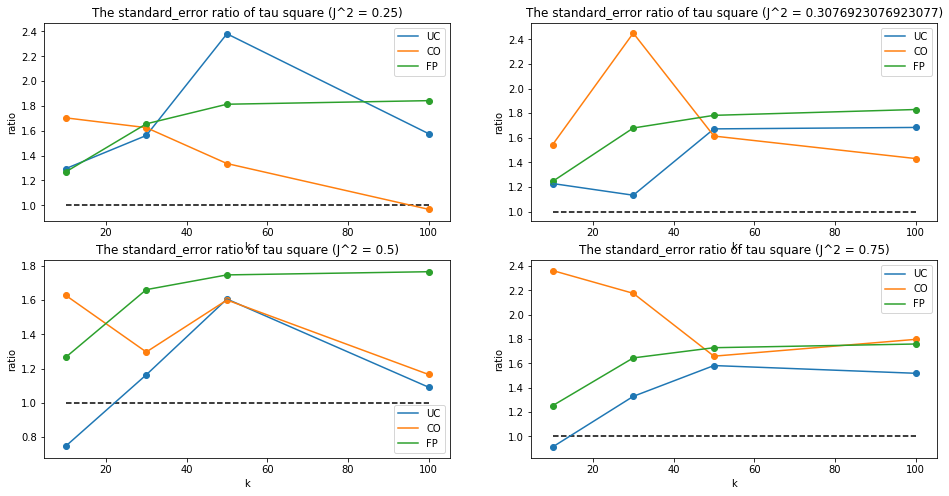

In [176]:
# plot of the standard_error ratio of tau square when J_sqaure = 0.25/0.31/0.5/0.75
fig = plt.figure(figsize=(16,8)) 
ax = fig.add_subplot(2,2,1)
plot_for_comparison(measurement='standard_error',x_axis='k', k = 100, J_square = 0.25, handler=ax)
ax = fig.add_subplot(2,2,2)
plot_for_comparison(measurement='standard_error',x_axis='k', k = 100, J_square = 0.3076923076923077, handler=ax)
ax = fig.add_subplot(2,2,3)
plot_for_comparison(measurement='standard_error',x_axis='k', k = 100, J_square = 0.5, handler=ax)
ax = fig.add_subplot(2,2,4)
plot_for_comparison(measurement='standard_error',x_axis='k', k = 100, J_square = 0.75, handler=ax)

# try multiple parameter settings
(i) Nmax/Nmin:  10, 25, 100, 250
(ii) Nmin: 10, 50

In [120]:
def array_generator_from_N(n_min,n_max,mu,sigma,tau,k=100):
    half_k = int(k/2)
    # n_array consists of half of N equal to min + the remaining half of N equal to max
    n_array = np.array([n_min]*half_k + [n_max]*half_k)
    u_array = 1/n_array
    # x_i ~ N(mu,tau^2)
    x_array = normal(mu,tau,k)
    # D_i ~ N(x_i, sigma^2*u_i)
    D_array = normal(x_array,sigma*u_array**0.5,k)
    return u_array, D_array

In [130]:
%%time
min_max_ratio_list = [10, 25, 100, 250]
n_min_list = [10, 50]
# k = 100 by default
n_replication = 100

# (J^2,n_min,max_min_ratio,n_replication)
UC_unknown_sigma_N, UC_known_sigma_N = np.empty((4,2,4,n_replication)), np.empty((4,2,4,n_replication))
CO_unknown_sigma_N, CO_known_sigma_N = np.empty((4,2,4,n_replication)), np.empty((4,2,4,n_replication))
FP_unknown_sigma_N, FP_known_sigma_N = np.empty((4,2,4,n_replication)), np.empty((4,2,4,n_replication))

for r in range(n_replication):
    for i in range(4):
        para_combination = parameter_constellation[i]
        mu_for_simulation = para_combination[0]
        sigma_square_for_simulation = para_combination[1]
        tau_square_for_simulation = para_combination[2]

        sigma_for_simulation = np.sqrt(sigma_square_for_simulation)
        tau_for_simulation = np.sqrt(tau_square_for_simulation)
        for j in range(2):
            n_min = n_min_list[j]
            n_max_list = [n_min*element for element in min_max_ratio_list]
            for h in range(4):
                n_max = n_max_list[h]
                #print(para_combination,n_min,n_max)
                each_replication_array = array_generator_from_N(n_min,n_max,mu_for_simulation,sigma_for_simulation,tau_for_simulation)
                each_replication_u_array = each_replication_array[0]
                each_replication_D_array = each_replication_array[1]
                
                # UC with unknown sigma
                UC_unknown_simulation = simulation_UC_unknown_sigma(each_replication_D_array,each_replication_u_array)
                UC_unknown_sigma_N[i][j][h][r] = UC_unknown_simulation[1] #the estimated value of tau^2
                
                # UC with known sigma
                UC_known_simulation = simulation_UC_known_sigma(each_replication_D_array,each_replication_u_array)
                UC_known_sigma_N[i][j][h][r] = UC_known_simulation[1] #the estimated value of tau^2
                
                # CO with unknown sigma
                CO_unknown_simulation = simulation_CO_unknown_sigma(each_replication_D_array,each_replication_u_array)
                CO_unknown_sigma_N[i][j][h][r] = CO_unknown_simulation[1] #the estimated value of tau^2
                
                # CO with known sigma
                CO_known_simulation = simulation_CO_known_sigma(each_replication_D_array,each_replication_u_array)
                CO_known_sigma_N[i][j][h][r] = CO_known_simulation[1] #the estimated value of tau^2
                
                # FP with unknown sigma
                FP_unknown_simulation = simulation_FP_unknown_sigma(each_replication_D_array,each_replication_u_array)
                FP_unknown_sigma_N[i][j][h][r] = FP_unknown_simulation[1] #the estimated value of tau^2
                
                # FP with known sigma
                FP_known_simulation = simulation_FP_known_sigma(each_replication_D_array,each_replication_u_array)
                FP_known_sigma_N[i][j][h][r] = FP_known_simulation[1] #the estimated value of tau^2
                

CPU times: user 1min 5s, sys: 100 ms, total: 1min 5s
Wall time: 1min 5s


In [132]:
%%time
# summarize the simulation results into the form of [bias, standard_error, mse]
UC_unknown_sigma_info_N = method_info(UC_unknown_sigma_N)
UC_known_sigma_info_N = method_info(UC_known_sigma_N)

CO_unknown_sigma_info_N = method_info(CO_unknown_sigma_N)
CO_known_sigma_info_N = method_info(CO_known_sigma_N)

FP_unknown_sigma_info_N = method_info(FP_unknown_sigma_N)
FP_known_sigma_info_N = method_info(FP_known_sigma_N)

CPU times: user 1.25 ms, sys: 843 µs, total: 2.09 ms
Wall time: 1.36 ms


In [134]:
# the bias/standard error/ mse ratio of tau^2 with unknown/known sigma
# [bias, standard error, mse]
UC_tau_square_ratio_N = UC_unknown_sigma_info_N/UC_known_sigma_info_N
CO_tau_square_ratio_N = CO_unknown_sigma_info_N/CO_known_sigma_info_N
FP_tau_square_ratio_N = FP_unknown_sigma_info_N/FP_known_sigma_info_N

In [135]:
print(UC_tau_square_ratio_N.shape)

(4, 2, 4, 3)


In [166]:
def plot_for_comparison_N(measurement,x_axis, n_min = 10, max_min_ratio = 10, J_square=0.25, handler=plt):
    measurement_dict = {'bias':0, 'standard_error':1, 'mse':2}
    measurement_index = measurement_dict[measurement]
    
    J_square_index = J_square_list.index(J_square)
    
    # when comparing all the three methods with varying n_min, we fix max_min_ratio=10 by default
    if x_axis == 'n_min':
        x  = n_min_list
        max_min_ratio_index = min_max_ratio_list.index(max_min_ratio)
        UC_ratio = UC_tau_square_ratio_N[J_square_index,:,max_min_ratio_index,measurement_index]
        CO_ratio = CO_tau_square_ratio_N[J_square_index,:,max_min_ratio_index,measurement_index]
        FP_ratio = FP_tau_square_ratio_N[J_square_index,:,max_min_ratio_index,measurement_index]
        
        handler.scatter(x,UC_ratio)
        handler.plot(x,UC_ratio,label='UC')
        handler.scatter(x,CO_ratio)
        handler.plot(x,CO_ratio,label='CO')
        handler.scatter(x,FP_ratio)
        handler.plot(x,FP_ratio,label='FP')
        handler.legend()
        handler.set_xlabel('n_min')
        handler.set_ylabel('ratio')
        handler.set_title('The '+measurement+ ' ratio of tau square (n_max/n_min = '+str(max_min_ratio)+')')
        handler.hlines(y=1,xmin=10,xmax=50,linestyles='dashed')
    
    if x_axis == 'max_min_ratio':
        x = min_max_ratio_list
        n_min_index = n_min_list.index(n_min)
        UC_ratio = UC_tau_square_ratio_N[J_square_index,n_min_index,:,measurement_index]
        CO_ratio = CO_tau_square_ratio_N[J_square_index,n_min_index,:,measurement_index]
        FP_ratio = FP_tau_square_ratio_N[J_square_index,n_min_index,:,measurement_index]
        
        handler.scatter(x,UC_ratio)
        handler.plot(x,UC_ratio,label='UC')
        handler.scatter(x,CO_ratio)
        handler.plot(x,CO_ratio,label='CO')
        handler.scatter(x,FP_ratio)
        handler.plot(x,FP_ratio,label='FP')
        handler.legend()
        handler.set_xlabel('n_max_min_ratio')
        handler.set_ylabel('ratio')
        handler.set_title('The '+measurement+ ' ratio of tau square (n_min = '+str(n_min)+')')
        handler.hlines(y=1,xmin=10,xmax=250,linestyles='dashed')
    return

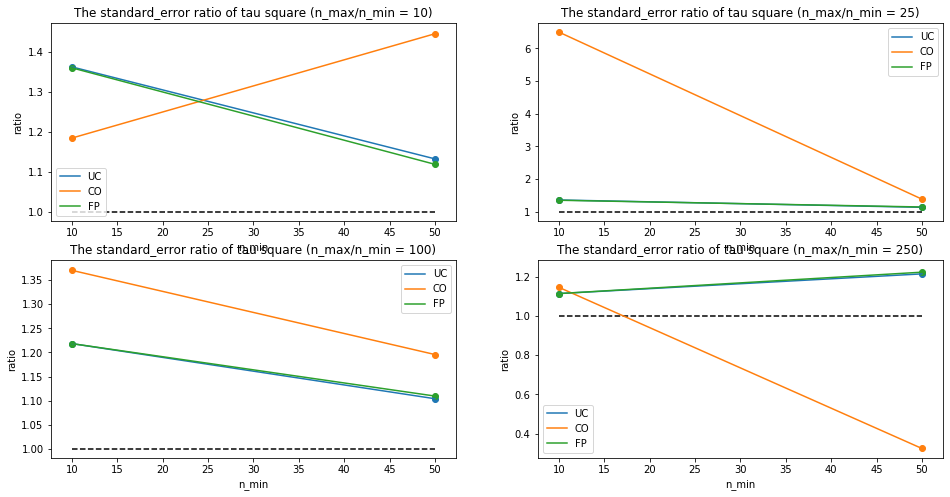

In [167]:
# plot of the standard_error ratio of tau square when max_min_ratio = 10/25/100/250
fig = plt.figure(figsize=(16,8)) ## setting over-all figure size (optional)
ax = fig.add_subplot(2,2,1)
plot_for_comparison_N(measurement='standard_error',x_axis='n_min', n_min = 10, max_min_ratio = 10, J_square=0.25, handler=ax)
ax = fig.add_subplot(2,2,2)
plot_for_comparison_N(measurement='standard_error',x_axis='n_min', n_min = 10, max_min_ratio = 25, J_square=0.25, handler=ax)
ax = fig.add_subplot(2,2,3)
plot_for_comparison_N(measurement='standard_error',x_axis='n_min', n_min = 10, max_min_ratio = 100, J_square=0.25, handler=ax)
ax = fig.add_subplot(2,2,4)
plot_for_comparison_N(measurement='standard_error',x_axis='n_min', n_min = 10, max_min_ratio = 250, J_square=0.25, handler=ax)


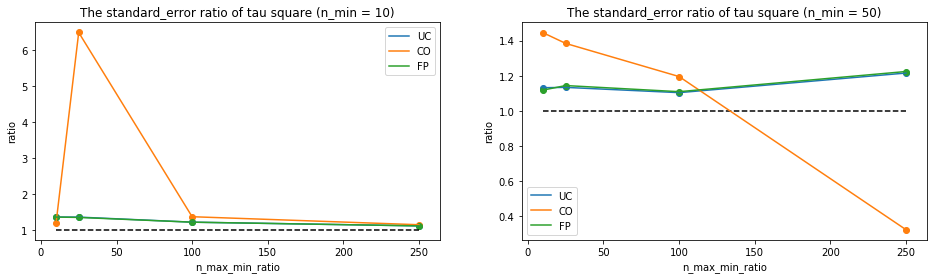

In [165]:
# plot of the standard_error ratio of tau square when n_min = 10/50
fig = plt.figure(figsize=(16,4)) ## setting over-all figure size (optional)
ax = fig.add_subplot(1,2,1)
plot_for_comparison_N(measurement='standard_error',x_axis='max_min_ratio', n_min = 10, max_min_ratio = 10, J_square=0.25, handler=ax)
ax = fig.add_subplot(1,2,2)
plot_for_comparison_N(measurement='standard_error',x_axis='max_min_ratio', n_min = 50, max_min_ratio = 25, J_square=0.25, handler=ax)
